# Naive Bayes Classifier

## Part A: Model Code

### Implement a Multinomial_NB model class.

In [64]:
# Design a Multinomial Naive Bayes classifier for performing binary classification

class Multinomial_NB(object):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        pass
    
    def fit(self, X, Y):
        self.X = X
        self.y = Y
        # total number of documents
        self.N_total_documents = X.shape[0]
        # count each class
        self.y_1_total_spam = np.sum( Y == 1)
        self.y_0_total_ham = Y.shape[0] - self.y_1_total_spam
        # vocabulary
        self.vocabulary = X.shape[1]
#         print("x: ", X.shape, "y: ", Y.shape)

        # Add the bias column
        X = np.c_[ np.ones((X.shape[0],1)), X ] 
        
        # create matrix of spam and ham
        temp = pd.DataFrame(data=X)
        temp["class"] = pd.DataFrame(data=Y)
        ham_index = temp["class"] == 0
        ham_table = np.array(temp[ham_index]) # the last column is class
        spam_index = temp["class"] == 1
        spam_table = np.array(temp[spam_index]) # the last column is class
        
#         # probability of each class: prior
#         sum_of_alpha = 0
#         for c in range(Y.shape[0]):
#             sum_of_alpha += self.alpha
            
        self.pi_0_ham =  self.y_0_total_ham /  self.N_total_documents
        self.pi_1_spam = self.y_1_total_spam /  self.N_total_documents
        print(Y, "\n", "self.y_1_total_spam: \n", self.y_1_total_spam)
        # probability of each component of the feature vector: likelihood
        self.theta_ham =  np.sum(ham_table[:, :ham_table.shape[1]-1], axis=0) / self.y_0_total_ham 
        self.theta_spam = np.sum(spam_table[:, :spam_table.shape[1]-1], axis=0) /  self.y_1_total_spam
        
    def predict(self, X):
        prediction = []
        # because of numerical instanbility, we use the log derive formula
        for row, sample in enumerate(X): # for each document ...
            spam_likelihood = 0
#             ham_likelihood = 0
            for column in range( len(sample) ): # for each component of the document ...
                if sample[column] == 1:
                    if self.theta_spam[column] == 0:
                        spam_likelihood += 0
                    else:
                        spam_likelihood += math.log( self.theta_spam[column] )
                else: # sample[i,j] == 0
                    if self.theta_spam[column] == 1.0:
                        spam_likelihood += 0
                    else:
                        spam_likelihood += math.log( abs(1 - self.theta_spam[column]) )
            prediction.append( abs(math.log(self.pi_1_spam) + spam_likelihood) )
    
       # results in term of classes( spam or ham) 
        r = []
        for p in prediction:
            if p >= 50: # 50%
                r.append(1)
            else:
                r.append(0)
        
        return np.array(r) # 1D array of predictions for each row in X
    
    
    
    def predict_log_proba(self, X):
        prediction_spam = []
        prediction_ham = []
        for row, sample in enumerate(X): # for each document ...
            spam_likelihood = 0
#             ham_likelihood = 0
            for column in range( len(sample) ): # for each component of the document ...
                if sample[column] == 1:
                    spam_likelihood += math.log2( self.theta_spam[column] )
                else: # sample[i,j] == 0
                    if self.theta_spam[column] == 1.0:
                        spam_lokelihood = 0
                    else:
                        spam_likelihood += math.log2( abs(1 - self.theta_spam[column]) )
                        
            prediction_spam.append( (math.log2(self.pi_1_spam) + spam_likelihood) )
            prediction_ham.append( math.log2(self.pi_1_spam) + (100 + spam_likelihood)) # why + not  -
            
        return  np.c_[ np.array(prediction_spam), np.array(prediction_ham)]

    

## Part B: Exploratory Data Analysis

### 2. Read file

In [2]:
import numpy as np
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import seaborn as sb
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets

In [68]:
dff_NB = pd.read_csv("C:/Users/pemesie/Documents/UNL/UNL/CSCE 478 Intro Machine Learning/datasets/SMSSpamCollection.csv", sep=",", header = None)


In [69]:
print(len(dff_NB))

# dff_NB = dff_NB.iloc[0:10, :]


5574


### 3. Summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles

In [70]:
dff_NB = pd.concat([dff_NB[1], dff_NB[0]], axis=1, sort=False)
dff_NB.columns = ["text", "target"]
dff_NB.head(5)

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [71]:
dff_NB.groupby("target").count()

,text
target,
ham,4827
spam,747


In [72]:
dff_NB['length'] = dff_NB['text'].map(lambda text: len(text))

dff_NB.groupby('target').length.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
ham,4827.0,71.527035,58.330761,2.0,33.0,52.0,93.0,910.0
spam,747.0,139.119143,28.998900,13.0,133.0,149.0,158.0,224.0


## 4. Generate a bar plot to display the class distribution

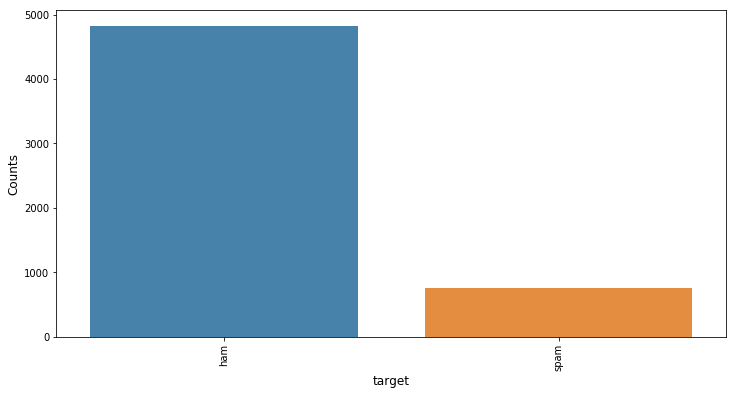

In [228]:
label_counts = dff_NB.target.value_counts()
plt.figure(figsize = (12,6))
sb.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('target', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

## Part C: Feature Extraction

### 9. Shuffle the rows of your data

In [73]:
df_NB = dff_NB.sample(frac=1)
# len(df_NB)

### 5. Normalize the “text” by performing stemming and lemmatization

In [74]:
# Lemmanization
from nltk.tokenize import word_tokenize

# lemmatizer = WordNetLemmatizer()
# df_NB['text_lemmatized'] = df_NB['text'].map(lambda text: lemmatizer.lemmatize(text))


# %%time
lemmatizer = WordNetLemmatizer()

df_NB['text_lemmatized'] = df_NB['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

In [75]:
# Observe a document before and after Lemmatization
print(df_NB['text_lemmatized'][1], "\n")
print(df_NB["text"][1])

ok lar ... joking wif u oni ... 

Ok lar... Joking wif u oni...


In [76]:
# Stemmeing
stemmer = PorterStemmer()
# word_list = df['text'].apply(word_tokenize)
df_NB['text_stemmed'] = df_NB['text'].map(lambda text: stemmer.stem(text))

In [77]:
# Observe a document before and after stemming
print(df_NB['text_stemmed'][1], "\n")
print(df_NB["text"][1])

ok lar... joking wif u oni... 

Ok lar... Joking wif u oni...


### 6. Generate word clouds

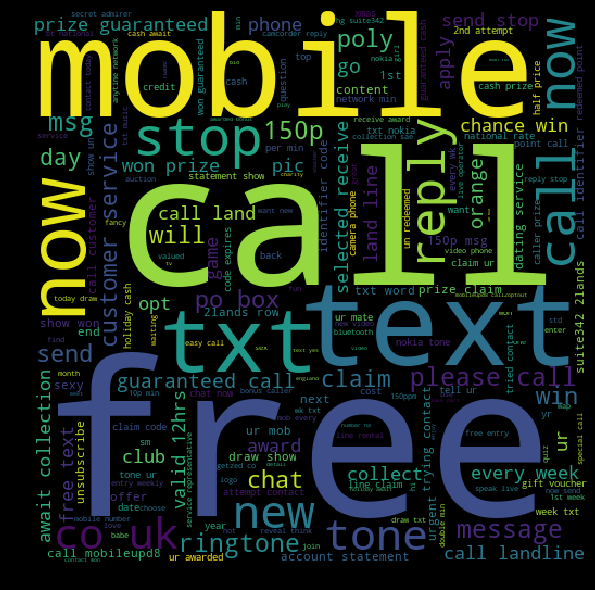

In [78]:
spam_words = ''.join(list(df_NB[df_NB['target']== 'spam']['text_lemmatized'])) 
spam_wordcloud = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

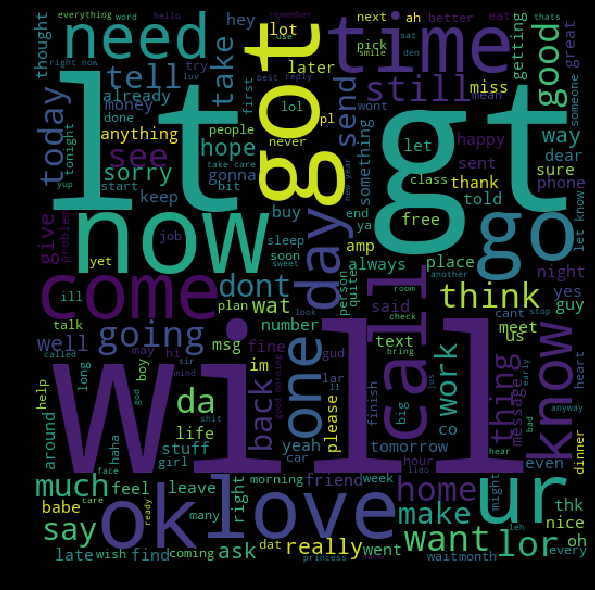

In [79]:
ham_words = ''.join(list(df_NB[df_NB['target']== 'ham']['text_stemmed'])) 
ham_wordcloud = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### 7. Remove the stop words from the text and convert the text content into numerical feature vectors.

In [80]:
count_vect = CountVectorizer(lowercase=True, stop_words='english', binary=True)
document_counts = count_vect.fit_transform(df_NB["text_lemmatized"]).todense() # CHECK WITH LEMMATIZATION

### 8. Create data or feature matrix X and the target vector Y

In [81]:
X_NB = np.array(document_counts)
print(X_NB.shape)


(5574, 7989)


In [82]:
# create a vector of class
y_NB = df_NB["target"]
y_NB[y_NB == "ham"] = 0
y_NB[y_NB == "spam"] = 1
y_NB = np.array(y_NB)
y_NB

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [337]:
# df_NB["target"]


### 10. Partition the data into train and test set (80%-20%)

In [16]:
# split data and return X_train, X_test, y_train, y_test

def split_data(X, y, split_percentage):
    
    test_data_size = int( X.shape[0] * split_percentage )
    train_data_size = X.shape[0] - test_data_size
    
    X_train = X[0:train_data_size, : ]
    y_train = y[0:train_data_size ]
    X_test = X[train_data_size+1 : X.shape[0], :]
    y_test = y[train_data_size+1:y.shape[0]]
    
    return  X_train, X_test , y_train , y_test

In [83]:
X_train_NB, X_test_NB , y_train_NB , y_test_NB =  split_data(X_NB, y_NB, 0.4) # Check if it works??????????????????

In [84]:
X_train_NB.shape

(3345, 7989)

In [191]:
# nb  = Multinomial_NB()
# nb.fit(X_train_NB, y_train_NB)
# prediction = nb.predict(X_test_NB)
# print("prediction:\n", prediction)

## Part D: Model Evaluation

In [104]:
# Compute F1 score
def F1_score_NB(Y, Y_predicted):
    
    precision =0
    false_negative= 0
    true_positive = 0
    false_positive = 0
    recall = 0
    
    for i, k in zip(Y, Y_predicted):
        if i == 0 and k == 0:
            false_negative +=1
        if i ==1 and k ==1:
            true_positive += 1
        if i == 0 and k == 1:
            false_negative +=1
    try:
        recall = true_positive / ( true_positive + false_negative )  
        precision = true_positive / (true_positive + false_positive )
        
        return 2 * ( (precision*recall) / (precision+recall) )
    except:
        return 0

In [132]:
# Implement kFold()
def kFold_NL(folds, data, labels, model, error_function, alpha):
    # partition data and labels
    one_fold_size = int(data.shape[0]/folds) # size of one fold
    partitions = []
    first_index = 0
    last_index = one_fold_size
    for i in range(folds):
#         x = data[first_index:last_index]
#         y = labels[first_index:last_index]
        partitions.append((first_index, last_index))
        first_index = last_index
        last_index += one_fold_size
        
    test_f1_score = []  
    # cross validation on partions
    for index in partitions:
        xtrain = np.delete(data, np.arange(index[0], index[1]), axis=0) 
        ytrain = np.delete(labels, np.arange(index[0], index[1]), axis=0)
        # fit the model
        multinomial_NB = model(alpha)
        multinomial_NB.fit(xtrain, ytrain)
        y_predicted = multinomial_NB.predict( data[index[0]:index[1], :] ) # using test folder
        #evaluate 
        f1_score = error_function( labels[index[0]:index[1]], y_predicted )
        test_f1_score.append(f1_score)
    
    # return 
    return np.mean(test_f1_score)


### 11. Model selection via Hyper-parameter tuning

In [152]:
alpha = [ 0.1,1, 0.5, 1.0, 1.5, 2.0]
cv = 5
previous_average_f1_score = float("inf")

for alp in alpha:
    average_f1_score = kFold_NL(cv, X_train_NB, y_train_NB, Multinomial_NB, F1_score_NB, alp)
    if average_f1_score < previous_average_f1_score:
        previous_average_f1_score = average_f1_score
        best_model = {'alpha: ', alp}

[1 0 1 ... 1 0 0] 
 self.y_1_total_spam: 
 345
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 344
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 338
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 336
[0 0 0 ... 0 0 1] 
 self.y_1_total_spam: 
 353
[1 0 1 ... 1 0 0] 
 self.y_1_total_spam: 
 345
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 344
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 338
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 336
[0 0 0 ... 0 0 1] 
 self.y_1_total_spam: 
 353
[1 0 1 ... 1 0 0] 
 self.y_1_total_spam: 
 345
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 344
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 338
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 336
[0 0 0 ... 0 0 1] 
 self.y_1_total_spam: 
 353
[1 0 1 ... 1 0 0] 
 self.y_1_total_spam: 
 345
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 344
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 338
[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 336
[0 0 0 ... 0 0 1] 
 self.y_1_total_spam: 
 353
[1 0 1 ... 1 0 0] 
 self.y_1_total_spam: 
 345
[0 0 0 ... 1 

In [153]:
best_model

{0.1, 'alpha: '}

### 13. Evaluate your model on the test data 

In [87]:
# Precision
def precision_NB(Y, Y_predicted):
    #truePositive = np.sum(Y == Y_predicted).astype(np.int)
    true_positive = 0
    false_positive =0
#     totalTruePositive = 0
    for i, k in zip(Y, Y_predicted):
        if i ==1 and k == 1:
            true_positive +=1
#             totalTruePositive +=1
        if i == 1 and k == 0:
            false_positive +=1
            
    if  (true_positive + false_positive) == 0:
        return 0
    else:
        return true_positive / (true_positive + false_positive )  

In [88]:
# recall
def recall_NB(Y, Y_predicted):
    #truePositive = np.sum(Y == Y_predicted).astype(np.int)
    true_positive = 0
    false_negative = 0
    for i, k in zip(Y, Y_predicted):
        if i == 0 and k == 1:
            false_negative +=1
        if i ==1 and k ==1:
            true_positive += 1
            
    if (true_positive + false_negative) == 0:
        return 0
    else:           
        return true_positive / ( true_positive + false_negative )


In [90]:
def confusion_matrix_NB(Y, Y_predicted):
    
    matrix = np.zeros((2,2))
    
    true_positive= 0
    true_negative = 0 
    false_negative = 0
    false_positive = 0
    #truePositive = np.sum(Y == Y_predicted) #.astype(np.int)
    
    for i, k in zip(Y, Y_predicted):
        if i == 0 and k == 0 :  
            false_positive += 1
        if i == 1 and k == 0 :
            true_negative += 1
        if i == 0 and k == 1 :
            false_negative += 1
        if i == 1 and k ==1:
            true_positive += 1
     
    matrix[0][0] = false_positive 
    matrix[0][1] = true_negative
    matrix[1][1] = true_positive
    matrix[1][0] = false_negative
            
    return matrix

In [91]:
# compute accuracy
def accuracy_score_NB(y, y_predicted):
    return np.mean(y == y_predicted)

In [154]:
best_model

{0.1, 'alpha: '}

In [157]:
# # nb  = Multinomial_NB()
# prediction = nb.predict(X_test_NB)
# print("prediction:\n", prediction)

nb  = Multinomial_NB(0.1)
nb.fit(X_train_NB, y_train_NB)

prediction = nb.predict(X_test_NB)
# print("prediction:\n", prediction)

[0 0 0 ... 1 0 0] 
 self.y_1_total_spam: 
 429


In [413]:
# print(y_NB)

In [158]:
acc = accuracy_score_NB(y_test_NB, prediction)
print("accuracy: ", acc)

accuracy:  0.8900359066427289


In [159]:
p = precision_NB(y_test_NB, prediction)
print("precision:\n", p)

precision:
 0.2744479495268139


In [160]:
f = F1_score_NB(y_test_NB, prediction)
print("F1_score: ", f)

F1_score:  0.014961215775767771


In [161]:
con = confusion_matrix_NB(y_test_NB, prediction)
print("confusion matrix: \n", con)

confusion matrix: 
 [[1896.  230.]
 [  15.   87.]]


### 14. Implement the Multivariate Bernoulli Naïve Bayes model. The hyperparameter should be the Additive or Laplace smoothing parameter alpha. 

In [142]:
# Design a Multinomial Naive Bayes classifier for performing binary classification

class Multivariate_NB(object):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        pass
    
    def fit(self, X, Y):
        self.X = X
        self.y = Y
        # total number of documents
        self.N_total_documents = X.shape[0]
        # count each class
        self.y_1_total_spam = np.sum( Y == 1)
        self.y_0_total_ham = Y.shape[0] - self.y_1_total_spam
          # vocabulary
        self.vocabulary = X.shape[1]

        # Add the bias column
        X = np.c_[ np.ones((X.shape[0],1)), X ] 
        
        # create matrix of spam and ham
        temp = pd.DataFrame(data=X)
        temp["class"] = pd.DataFrame(data=Y)
        ham_index = temp["class"] == 0
        ham_table = np.array(temp[ham_index]) # the last column is class
        spam_index = temp["class"] == 1
        spam_table = np.array(temp[spam_index]) # the last column is class
        
        # probability of each class: prior
        sum_of_alpha = 0
        for c in range(Y.shape[0]):
            sum_of_alpha += self.alpha
            
        self.pi_0_ham = (self.alpha  + self.y_0_total_ham) / ( 2 + self.N_total_documents) # 2, we are doing binary classification
        self.pi_1_spam = (self.alpha  + self.y_1_total_spam) / (2 + self.N_total_documents)
      
        # probability of each component of the feature vector: likelihood
        self.theta_ham = (self.alpha + np.sum(ham_table[:, :ham_table.shape[1]-1], axis=0)) / ( self.vocabulary + self.y_0_total_ham) 
        self.theta_spam = (self.alpha + np.sum(spam_table[:, :spam_table.shape[1]-1], axis=0)) / ( self.vocabulary + self.y_1_total_spam)

        
        
        
    def predict(self, X):
        prediction = []
        # because of numerical instanbility, we use the log derive formula
        for row, sample in enumerate(X): # for each document ...
            spam_likelihood = 0
#             ham_likelihood = 0
            for column in range( len(sample) ): # for each component of the document ...
                if sample[column] == 1:
                    if self.theta_spam[column] == 0:
                        spam_likelihood += 0
                    else:
                        spam_likelihood += math.log( self.theta_spam[column] )
                else: # sample[i,j] == 0
                    if self.theta_spam[column] == 1.0:
                        spam_likelihood += 0
                    else:
                        spam_likelihood += math.log( abs(1 - self.theta_spam[column]) )
            prediction.append( abs(math.log(self.pi_1_spam) + spam_likelihood) )   
            
       # results in term of classes( spam or ham) 
        r = []
        for p in prediction:
            if p >= 50: # 50%
                r.append(1)
            else:
                r.append(0)
        
        return np.array(r) # 1D array of predictions for each row in X
    
    
    
#     def predict(self, X):
#         prediction = []
#         # because of numerical instanbility, we use the log derive formula
#         for row, sample in enumerate(X): # for each document ...
#             spam_likelihood = 0
# #             ham_likelihood = 0
#             for column in range( len(sample) ): # for each component of the document ...
#                 if sample[column] == 1:
#                     spam_likelihood += math.log2( self.theta_spam[column] )
#                 else: # sample[i,j] == 0
#                     spam_likelihood += math.log2( abs(1 - self.theta_spam[column]) )
#             prediction.append( abs(math.log2(self.pi_1_spam) + spam_likelihood) )
    
#        # results in term of classes( spam or ham) 
#         r = []
#         for p in prediction:
#             if p >= 50: # 50%
#                 r.append(1)
#             else:
#                 r.append(0)
        
#         return np.array(r) # 1D array of predictions for each row in X
    
 
    

In [145]:
alpha = [ 0.1,1, 0.5, 1.0, 1.5, 2.0]
cv = 5
previous_average_f1_score = float("inf")

for alp in alpha:
    average_f1_score = kFold_NL(cv, X_train_NB, y_train_NB, Multivariate_NB, F1_score_NB, alp)
    if average_f1_score < previous_average_f1_score:
        previous_average_f1_score = average_f1_score
        best_model = {'alpha: ', alp}

In [146]:
best_model

{1.5, 'alpha: '}

In [147]:
nb  = Multivariate_NB(1.5)
nb.fit(X_train_NB, y_train_NB)

prediction = nb.predict(X_test_NB)

In [148]:
acc = accuracy_score_NB(y_test_NB, prediction)
print("accuracy: ", acc)

accuracy:  0.5785457809694794


In [149]:
p = precision_NB(y_test_NB, prediction)
print("precision:\n", p)

precision:
 0.9684542586750788


In [150]:
f = F1_score_NB(y_test_NB, prediction)
print("F1_score: ", f)

F1_score:  0.15543987184339378


In [151]:
con = confusion_matrix_NB(y_test_NB, prediction)
print("confusion matrix: \n", con)

confusion matrix: 
 [[982.  10.]
 [929. 307.]]


# Logistic Regression: Multi-Class Classification

## Part A: Model Code 

### 15. Implement the following function to convert the vector of class indices into a matrix containing a one-hot vector for each instanc

In [66]:
def one_hot_labels(y):
    unique = np.unique(y) # get the unique values
    one_hot = np.zeros((y.shape[0], unique.shape[0]))
  
    for i in range(one_hot.shape[0]):
        one_hot[i][ y[i] - 1 ] = 1
        
    return one_hot

### 16. Implement the following function that computes the softmax score or the normalized exponential of the score of a feature. 

In [67]:
# return Y_proba : ndarray. Probability of a sample belonging to various classe
def softmax(score):
    exp_score = np.exp(score)
    sum_exp_score_per_instance = np.sum(exp_score, axis=1) #:, :exp_score.shape[1]], axis=1) # sum on columns
    Y_proba = exp_score.T / sum_exp_score_per_instance
    return Y_proba.T

### 17. Implement the following function to compute the cross-entropy loss

In [179]:
# return cost: float   
def cross_entropy_loss(Y_one_hot, Y_proba):
    N = Y_one_hot.shape[0]
    loss_function = (-1 / N ) * np.sum(Y_one_hot * np.log(Y_proba)) #+ (1/2) * np.sum( self.theta_hat*self.theta_hat)
    return loss_function

### 18. Implement a Softmax_Regression model class. The “fit” method implements the batch gradient descent algorithm. Also, the loss in the gradient descent uses 1st order derivative.   

In [181]:
# softmax regression

class Softmax_Regression(object):
    
    def __init__(self):
        
        self.theta_hat =  None

    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, early_stopping=False, validation_fraction=0.1, **kwarg): #(self, X, y, learning_rate, epochs, tol, regularizer,lambd,**kwargs):
        
        self.theta_hat = np.zeros( (X.shape[1], Y.shape[1]) )
        self.one_hot = Y
        
        # Compute l2
        def L2():
            return lambd *  self.theta_hat
        
        # Compute l1
        def L1():
            return lambd * np.sign(self.theta_hat)
        
        
        norms = {"l2": L2, "l1": L1}
        
        # Compute theta_hat
        def compute_theta_hat():
            # compute score matrix: a score of each sample belonging to class c
            score = np.dot( X, self.theta_hat)
            # estimate the probability U_c that the instance belongs to class c
            Y_proba = softmax(score)
            
            if regularizer is None: # regularization is either L1, L2 or None
                # y, is one_hot matrix or y of class??????
                self.theta_hat = self.theta_hat - (learning_rate/X.shape[0]) * X.T.dot( (Y_proba - self.one_hot) ) 
            else:
                self.theta_hat = self.theta_hat - (learning_rate/X.shape[0]) * X.T.dot( (Y_proba - self.one_hot) ) + norms[ regularizer ]()        
          
        
        
        def error():
            compute_theta_hat()
            score = np.dot(X, self.theta_hat)
            Y_proba = softmax(score)
            print(type(cross_entropy_loss(self.one_hot, Y_proba) ))
            error = cross_entropy_loss(self.one_hot, Y_proba) 
            return error
          
       
            
       # minimize theta_ha
        if tol is None:
            
            while epochs > 0:
                compute_theta_hat()
                epochs -= 1
        else: 
            error = error()
            previous_error = 0
            
            while error < previous_error - tol:
                previous_error = error
                error = error()
                
    
    # prediction function: 
    '''
        column index of prediction_matrix corresponds to class
        return index of highest prob in each row
    '''
    def predict(self, X):
        score = np.dot(X, self.theta_hat)
        prediction_matrix = softmax(score)
        return  [ np.argmax(j, axis=0) for _, j in enumerate(prediction_matrix) ]
        

## Part B: Exploratory Data Analysis

### 19. Read the Iris data using the sklearn.datasets.load_iris method. 

In [70]:
# Load data
iris = datasets.load_iris()

df = pd.DataFrame(iris.data,columns=iris.feature_names)
df = pd.concat([df,pd.Series(iris.target,name='target')],axis=1)
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


 ## 20. Summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles. 

In [71]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


### 21. Shuffle the rows of your data.

In [72]:
df_s = df.sample(frac=1)

In [73]:
X = df_s.iloc[:, :-1]
yy = df_s['target']

### 22. Generate pair plots using the seaborn package to identify redundant features.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


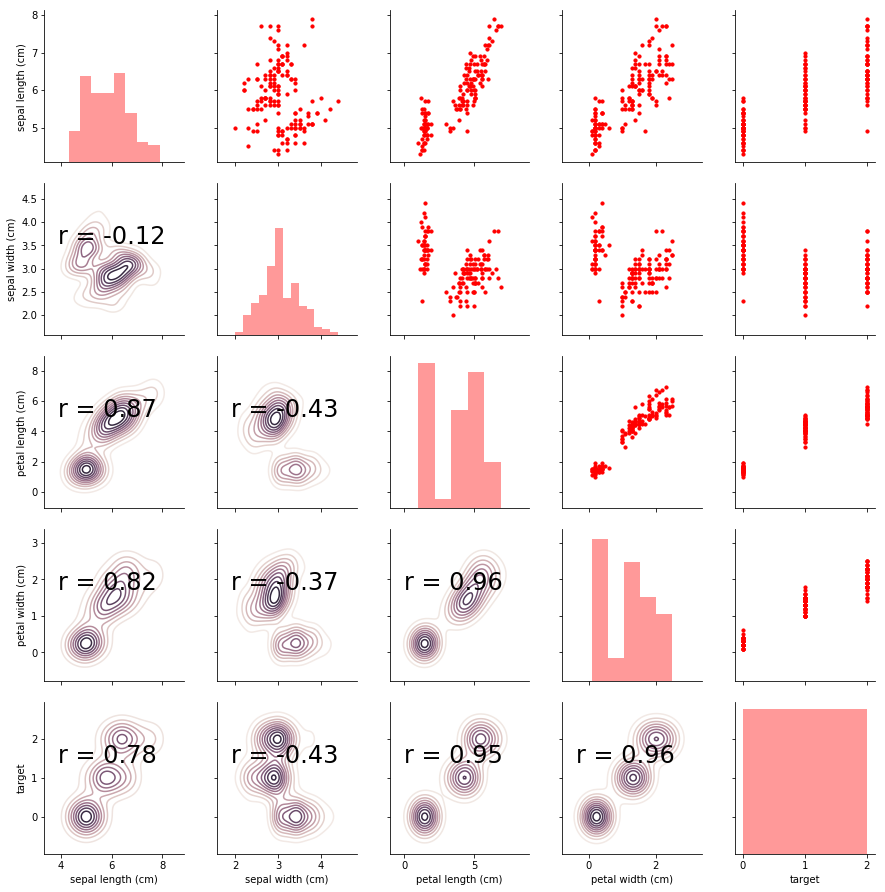

In [29]:
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc( X, y, **kws):
    r, _ = stats.pearsonr( X, y) #np.array(df_s.iloc[:, :-1]), np.array(df_s['target']) )
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [ ]:
# Redundancy
'''
    The pair plot above shows that some features are correlated.
    sepal length -> petal length
    sepal length -> petal with
    petal length -> petal width
    
'''

### 23. Scale the features. 

In [74]:
def standardization(X):
    
    mean = np.zeros(X.shape[1])
    sdt = np.zeros(X.shape[1])
    
    for index in range( 0, X.shape[1] ):
        mean[index] = X[:,index].mean()
        sdt[index] = X[:, index].std()
        X[:, index] =  ( X[:, index] - mean[index]  ) / sdt[index]
        
    return X

In [75]:
X = np.array(X)
yy = np.array(yy)
# scale the data
X = standardization(X)
# create the one_hot_labels
y = one_hot_labels(yy)

### 24. Partition the data into train and test set.

In [76]:
# split data and return X_train, X_test, y_train, y_test

def split_data(X, y, split_percentage):
    
    test_data_size = int( X.shape[0] * split_percentage )
    train_data_size = X.shape[0] - test_data_size
    
    X_train = X[0:train_data_size, : ]
    y_train = y[0:train_data_size ]
    X_test = X[train_data_size+1 : X.shape[0], :]
    y_test = y[train_data_size+1:y.shape[0]]
    
    return  X_train, X_test , y_train , y_test

In [77]:
split_percentage = 0.2
X_train, X_test, y_train, y_test = split_data(X, y, split_percentage)

# Part C: Model Evaluation 

In [170]:
# compute accuracy
def accuracy_score(Y, Y_predicted):
    true_positive = 0
    false_positive = 0
    
    for index, y_pred in enumerate( Y_predicted):
        if Y[index, y_pred] == 1 and y_pred == np.argmax(Y[index], axis=0):
            true_positive += 1
        elif Y[index, y_pred] ==1 and y_pred != np.argmax(Y[index], axis=0):
            false_positive += 1
    
    accuracy = (true_positive + false_positive) / Y.shape[0]
    
    return accuracy

In [189]:
# confusion matrix
def confusion_matrix(Y, Y_predicted):
    
    matrix = np.zeros((2,2))
    
    true_positive= 0
    true_negative = 0 
    false_negative = 0
    false_positive = 0
   
    for index, y_pred in enumerate( Y_predicted):

        if Y[index, y_pred] == 0 and y_pred != np.argmax(Y[index], axis=0):
            false_negative += 1
        if Y[index, y_pred] ==1 and y_pred != np.argmax(Y[index], axis=0):
            false_positive +=1
        if Y[index, y_pred] == 1 and y_pred == np.argmax(Y[index], axis=0):
            true_positive += 1
        if Y[index, y_pred] == 0 and y_pred == np.argmax(Y[index], axis=0):
            true_negative +=1
      
        
    matrix[0][0] = true_negative
    matrix[1][0] = false_negative
    matrix[0][1] = false_positive
    matrix[1][1] = true_positive
    
            
    return matrix

In [78]:
def kFold(folds, data, labels, model, error_function, **kwargs):
    # partition data and labels
    one_fold_size = int(data.shape[0]/folds) # size of one fold
    partitions = []
    first_index = 0
    last_index = one_fold_size
    for i in range(folds):
#         x = data[first_index:last_index]
#         y = labels[first_index:last_index]
        partitions.append((first_index, last_index))
        first_index = last_index
        last_index += one_fold_size
        
    test_accuracy = []  
    # cross validation on partions
    for index in partitions:
        xtrain = np.delete(data, np.arange(index[0], index[1]), axis=0) 
        ytrain = np.delete(labels, np.arange(index[0], index[1]), axis=0)
        # fit the model
        softmax_regr = model()
        softmax_regr.fit(xtrain, ytrain, kwargs['learning_rate'], kwargs['epochs'], kwargs['tol'], kwargs['regularizer'], kwargs['lambd'], kwargs['early_stopping'], kwargs['validation_fraction'])
        class_predicted = softmax_regr.predict( data[index[0]:index[1], :] ) # using test folder
        #evaluate the accuracy 
        accuracy = accuracy_score( labels[index[0]:index[1], :], class_predicted )
        test_accuracy.append(accuracy)
    
    # return the average accuracy
    return np.mean(test_accuracy)

### 25. Model selection via Hyper-parameter tuning: Use the kFold

In [182]:
# Determine the best model (model selection) based on the overall performance (lowest average error).
lambd = [1.0, 0.1, 0.01, 0.001, 0.0001] 
tol = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001] 
learning_rate = [0.1, 0.01, 0.001]
regularizer = ['l1', 'l2'] 
kwargs = {}
cv = 5
results = []
previous_accuracy = float("inf")

for lamb in lambd:
    for to in tol:
        for rate in learning_rate:
            for regul in regularizer:
                kwargs = {'lambd': lamb, 'tol': to, 'learning_rate': rate, 'regularizer': regul, 'epochs': 0, 'early_stopping': 0, 'validation_fraction': 0}
                average_accuracy = kFold(cv, X_train, y_train, Softmax_Regression, accuracy_score, **kwargs)
                # store the combinasion of parameters in a dictionary
                model = {'lambda': lamb, 'tol': to, 'learning rate': rate, 'regularizer': regul, 'average accuracy': average_accuracy} 
                results.append( model )
                # select the best model
                if average_accuracy < previous_accuracy:
                    previous_accuracy = average_accuracy
                    best_model = model
                    

In [183]:
best_model

{'lambda': 1.0,
 'tol': 0.001,
 'learning rate': 0.1,
 'regularizer': 'l1',
 'average accuracy': 0.8083333333333333}

### 26. Evaluate your model on the test data and report the accuracy and confusion matrix. 

In [184]:
softmax_reg = Softmax_Regression()
softmax_reg.fit(X_train, y_train, 0.1, 1000, 0.001, "l1", 1, False,)
pred = softmax_reg.predict(X_test)

In [185]:
# compute accuracy
print("accuracy: ", accuracy_score(y_test, pred))

accuracy:  0.8275862068965517


In [190]:
# compute confusion matrix
print("confusion matrix: \n", confusion_matrix(y_test, pred))
# (Y[index], Y[index, y_pred], np.max(Y[index], axis=0), np.argmax(Y[index], axis=0), Y_predicted[index])

confusion matrix: 
 [[ 0.  0.]
 [ 5. 24.]]
